In [1]:
import numpy as np
from matplotlib import pyplot as plt, cm
from mpl_toolkits.mplot3d import Axes3D

In [16]:
nx = 101
ny = 101
nt = 500 
nit = 50
c = 1
length = 1
dx = length / (nx-1)
dy = length / (ny-1)
x = np.linspace(0,length,nx)
y = np.linspace(0,length,ny)
X, Y = np.meshgrid(x, y)

rho = 1
nu = 0.01
dt = 0.001

u = np.zeros((ny,nx))
v = np.zeros((ny,nx))
p = np.zeros((ny,nx))
b = np.zeros((ny,nx))

print("Reynold's number =", c*length/nu)

Reynold's number = 100.0


In [17]:
def build_up_b(b, rho, dt, u, v, dx, dy):
    
    b[1:-1, 1:-1] = (rho * (1 / dt * 
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / 
                     (2 * dx) + (v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy)) -
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx))**2 -
                      2 * ((u[2:, 1:-1] - u[0:-2, 1:-1]) / (2 * dy) *
                           (v[1:-1, 2:] - v[1:-1, 0:-2]) / (2 * dx))-
                          ((v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy))**2))


    return b

In [18]:
# This is another version of pressure_poisson function with l1norm_target
def pressure_poisson_l1norm(p, dx, dy, b, l1norm_target):
    pn = np.empty_like(p)
    pn = p.copy()

    l1norm = 1
    small = 1e-8
    niter = 0
    while l1norm > l1norm_target:
        niter += 1   # count the number of iterations for convergence
        pn = p.copy()
        p[1:-1, 1:-1] = (((pn[1:-1, 2:] + pn[1:-1, 0:-2]) * dy**2 + 
                          (pn[2:, 1:-1] + pn[0:-2, 1:-1]) * dx**2) /
                          (2 * (dx**2 + dy**2)) -
                          dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * 
                          b[1:-1,1:-1])

        p[:, -1] = p[:, -2] # dp/dx = 0 at x = 2
        p[0, :] = p[1, :]   # dp/dy = 0 at y = 0
        p[:, 0] = p[:, 1]   # dp/dx = 0 at x = 0
        p[-1, :] = 0        # p = 0 at y = 2
        l1norm = (np.sum(np.abs(p[:]-pn[:])) / (np.sum(np.abs(pn[:]))+small))
        
    return p, niter

In [19]:
def velocity_u_update(u, dx, dy, dt, rho, p, un, vn):
    
    u[1:-1, 1:-1] = (un[1:-1, 1:-1]-
                    un[1:-1, 1:-1] * dt / dx *
                    (un[1:-1, 1:-1] - un[1:-1, 0:-2]) -
                    vn[1:-1, 1:-1] * dt / dy *
                    (un[1:-1, 1:-1] - un[0:-2, 1:-1]) -
                    dt / (2 * rho * dx) * (p[1:-1, 2:] - p[1:-1, 0:-2]) +
                    nu * (dt / dx**2 *
                    (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                    dt / dy**2 *
                    (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])))
    return u

def velocity_v_update(v, dx, dy, dt, rho, p, un, vn):
    
    v[1:-1,1:-1] = (vn[1:-1, 1:-1] -
                    un[1:-1, 1:-1] * dt / dx *
                    (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
                    vn[1:-1, 1:-1] * dt / dy *
                    (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) -
                    dt / (2 * rho * dy) * (p[2:, 1:-1] - p[0:-2, 1:-1]) +
                    nu * (dt / dx**2 *
                    (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                    dt / dy**2 *
                    (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1])))
    return v

def compute_F(c):
    denom = abs(c) + 1e-6
    pos_part = np.maximum(c/denom, 0)
    neg_part = np.maximum(-c/denom, 0)
    return pos_part, neg_part

def velocity_u_upwind_update(u, dx, dy, dt, rho, p, un, vn):
    #F = lambda c: (max(c/(abs(c)+1e-6), 0), max(-c/(abs(c)+1e-6), 0))
    #F_vectorized = np.vectorize(F) # vectorize function F to support element-wise operations on arrays
    fe1, fe2 = compute_F(un)       
    fw1, fw2 = fe1, fe2
    ue = un[1:-1, 1:-1] * fe1[1:-1, 1:-1] + un[1:-1, 2:] * fe2[1:-1, 1:-1]     
    uw = un[1:-1, 0:-2] * fw1[1:-1, 1:-1] + un[1:-1, 1:-1]* fw2[1:-1, 1:-1]

    fnorth1, fnorth2 = compute_F(vn)       
    fs1, fs2 = fnorth1, fnorth2
    unorth = un[1:-1, 1:-1] * fnorth1[1:-1, 1:-1] + un[2:, 1:-1] * fnorth2[1:-1, 1:-1]     
    us = un[0:-2, 1:-1] * fs1[1:-1, 1:-1] + un[1:-1, 1:-1]* fs2[1:-1, 1:-1]
   
    u[1:-1, 1:-1] = (un[1:-1, 1:-1]-
                    un[1:-1, 1:-1] * dt / dx *
                    (ue - uw) -
                    vn[1:-1, 1:-1] * dt / dy *
                    (unorth - us) -
                    dt / (2 * rho * dx) * (p[1:-1, 2:] - p[1:-1, 0:-2]) +
                    nu * (dt / dx**2 *
                    (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                    dt / dy**2 *
                    (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])))
    return u

def velocity_v_upwind_update(v, dx, dy, dt, rho, p, un, vn):
    
    #F = lambda c: (max(c/(abs(c)+1e-6), 0), max(-c/(abs(c)+1e-6), 0))
    #F_vectorized = np.vectorize(F) # vectorize function F to support element-wise operations on arrays
    fe1, fe2 = compute_F(un)       
    fw1, fw2 = fe1, fe2
    ve = vn[1:-1, 1:-1] * fe1[1:-1, 1:-1] + vn[1:-1, 2:] * fe2[1:-1, 1:-1]     
    vw = vn[1:-1, 0:-2] * fw1[1:-1, 1:-1] + vn[1:-1, 1:-1]* fw2[1:-1, 1:-1]

    fnorth1, fnorth2 = compute_F(vn)       
    fs1, fs2 = fnorth1, fnorth2
    vnorth = vn[1:-1, 1:-1] * fnorth1[1:-1, 1:-1] + vn[2:, 1:-1] * fnorth2[1:-1, 1:-1]     
    vs = vn[0:-2, 1:-1] * fs1[1:-1, 1:-1] + vn[1:-1, 1:-1]* fs2[1:-1, 1:-1]
    
    v[1:-1,1:-1] = (vn[1:-1, 1:-1] -
                    un[1:-1, 1:-1] * dt / dx *
                    (ve - vw) -
                    vn[1:-1, 1:-1] * dt / dy *
                    (vnorth - vs) -
                    dt / (2 * rho * dy) * (p[2:, 1:-1] - p[0:-2, 1:-1]) +
                    nu * (dt / dx**2 *
                    (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                    dt / dy**2 *
                    (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1])))
    return v



# a = np.ones((5,5))
# F = lambda c: (max(c/(abs(c)+1e-6), 0), max(-c/(abs(c)+1e-6), 0))
# F_vectorized = np.vectorize(F)
# a1,a2=F_vectorized(a)
# a1

In [20]:
def cavity_flow(nt, u, v, dt, dx, dy, p, rho, nu):
    un = np.empty_like(u)
    vn = np.empty_like(v)
    pn = np.empty_like(p)
    b = np.zeros((ny, nx))
    small = 1e-8    
    for n in range(nt):
        un = u.copy()
        vn = v.copy()
        pn = p.copy()
        b = build_up_b(b, rho, dt, u, v, dx, dy)
        #p = pressure_poisson(p, dx, dy, b)
        p, niter = pressure_poisson_l1norm(p, dx, dy, b, 1e-4)
        #print(niter)

        #u = velocity_u_update(u, dx, dy, dt, rho, p, un, vn)
        #v = velocity_v_update(v, dx, dy, dt, rho, p, un, vn)
        u = velocity_u_upwind_update(u, dx, dy, dt, rho, p, un, vn)
        v = velocity_v_upwind_update(v, dx, dy, dt, rho, p, un, vn)
        
        u[0, :]  = 0
        u[:, 0]  = 0
        u[:, -1] = 0
        u[-1, :] = c    # set velocity on cavity lid equal to c
        v[0, :]  = 0
        v[-1, :] = 0
        v[:, 0]  = 0
        v[:, -1] = 0
        
    l1norm_u = (np.sum(np.abs(u[:]-un[:])) / (np.sum(np.abs(un[:]))+small))
    l1norm_v = (np.sum(np.abs(v[:]-vn[:])) / (np.sum(np.abs(vn[:]))+small))
    l1norm_p = (np.sum(np.abs(p[:]-pn[:])) / (np.sum(np.abs(pn[:]))+small))
    print("l1norm_u = ",  l1norm_u, "l1norm_v = ",  l1norm_v, "l1norm_p = ",  l1norm_p)
    return u, v, p

In [21]:
#%%timeit -r 1 -n 1
u = np.zeros((ny, nx))
v = np.zeros((ny, nx))
p = np.zeros((ny, nx))
b = np.zeros((ny, nx))
nt = 10000
u, v, p = cavity_flow(nt, u, v, dt, dx, dy, p, rho, nu)

l1norm_u =  1.3176298819486995e-06 l1norm_v =  1.6973388823286147e-06 l1norm_p =  1.1557951326021192e-06


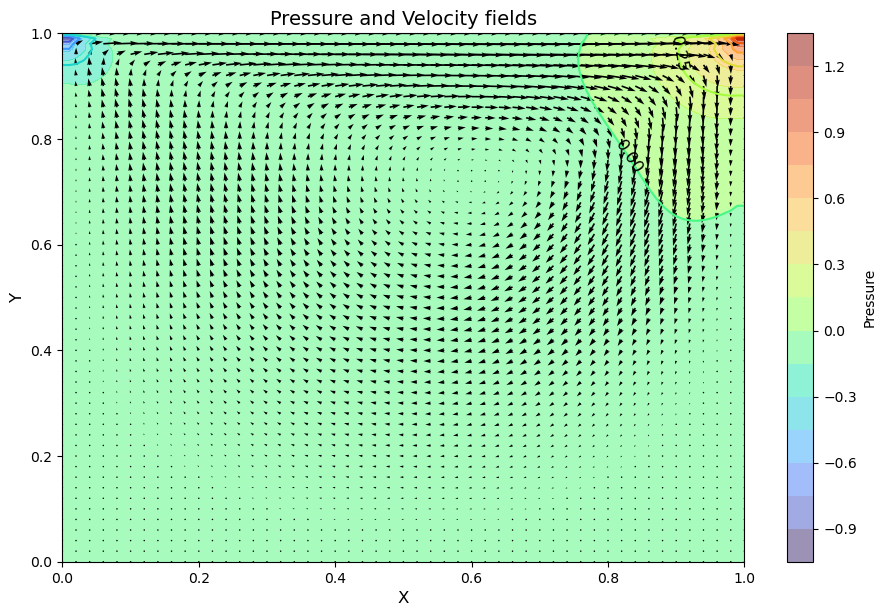

In [22]:
# Create figure and set dpi and figure size
fig = plt.figure(figsize=(11,7), dpi=100)

# Contourf plot for pressure field with colorbar
cf = plt.contourf(X, Y, p, alpha=0.5, cmap='turbo', levels=20)
plt.colorbar(cf, label='Pressure')

# Contour plot for pressure field outlines
contour = plt.contour(X, Y, p, cmap='turbo', levels=10)
plt.clabel(contour, inline=False, fontsize=12, colors = 'black')

# Quiver plot for velocity field
quiv = plt.quiver(X[::2, ::2], Y[::2, ::2], u[::2, ::2], v[::2, ::2]) 

# Setting labels for the x and y axes
plt.xlabel('X', fontsize=12)
plt.ylabel('Y', fontsize=12)

# Setting the title for the plot
plt.title('Pressure and Velocity fields', fontsize=14)

# Display the plot
plt.show()

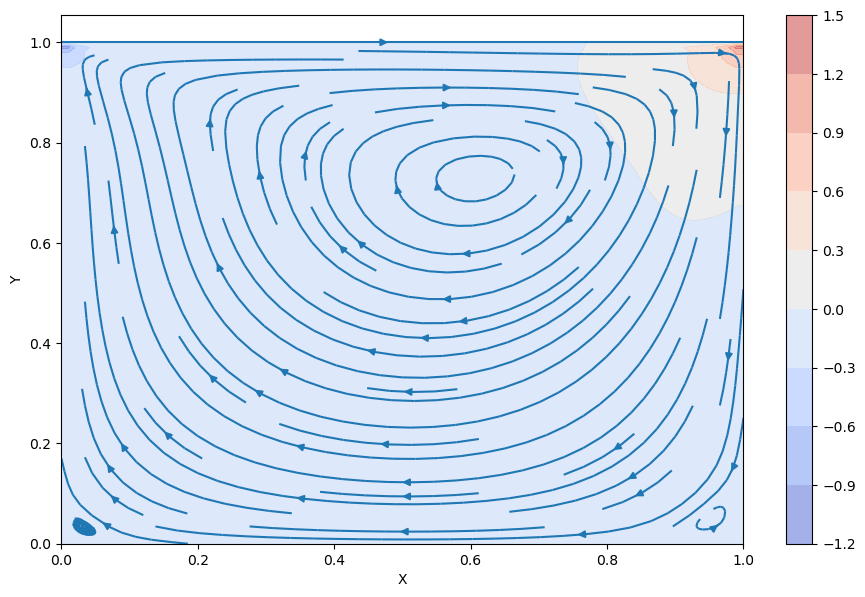

In [23]:
fig = plt.figure(figsize=(11, 7), dpi=100)
plt.contourf(X, Y, p, alpha=0.5, cmap=cm.coolwarm)
plt.colorbar()
#plt.contour(X, Y, p, cmap=cm.coolwarm)
plt.streamplot(X, Y, u, v)
plt.xlabel('X')
plt.ylabel('Y');

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the txt file
with open('Ghia-1982.txt', 'r') as file:
    lines = file.readlines()

# Adjust the lines range to match your data
lines = lines[5:-7]  # Adjust these numbers

# Process lines to obtain data
data = [list(map(float, line.split())) for line in lines]

# Create DataFrame from data
df = pd.DataFrame(data, columns=['y', 'Re=100', 'Re=400', 'Re=1000', 'Re=3200', 'Re=5000', 'Re=7500', 'Re=10000'])

# Set y as index
df.set_index('y', inplace=True)

# Plotting
# plt.figure(figsize=(10,8))
# for column in df.columns:
#     plt.plot(df[column].values, df.index.values, label=column) # use .values to get numpy arrays

# plt.xlabel('u-velocity')
# plt.ylabel('y')
# plt.title('u-velocity for different y and Re')
# plt.legend()
# plt.gca().invert_yaxis()  # To invert y-axis
# plt.grid(True)
# plt.show()

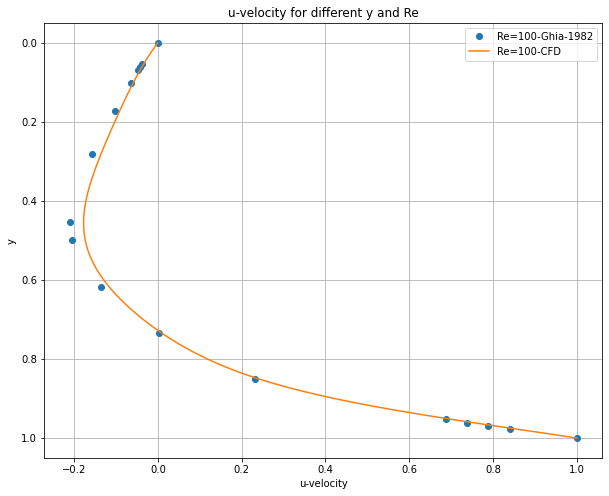

In [26]:
# Plotting
plt.figure(figsize=(10,8))

plt.plot(df['Re=100'].values, df.index.values, 'o', label='Re=100-Ghia-1982') # use .values to get numpy arrays
plt.plot(u[:,int(ny/2)], y, label='Re=100-CFD') # 

plt.xlabel('u-velocity')
plt.ylabel('y')
plt.title('u-velocity for different y and Re')
plt.legend()
plt.gca().invert_yaxis()  # To invert y-axis
plt.grid(True)
plt.show()

In [13]:
rho = 1
c= 4
nu = 0.01
dt = 0.001

u = np.zeros((ny,nx))
v = np.zeros((ny,nx))
p = np.zeros((ny,nx))
b = np.zeros((ny,nx))

print("Reynold's number =", c*length/nu)

Reynold's number = 400.0


l1norm_u =  1.2510773434793988e-07 l1norm_v =  1.744592732690087e-07 l1norm_p =  1.4299899725287116e-07


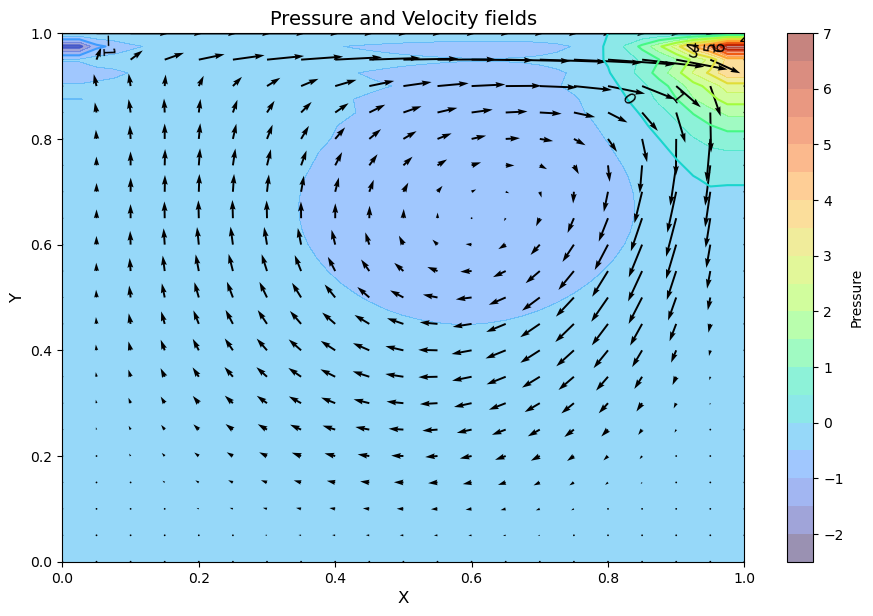

In [14]:
nt = 10000
u, v, p = cavity_flow(nt, u, v, dt, dx, dy, p, rho, nu)

# Create figure and set dpi and figure size
fig = plt.figure(figsize=(11,7), dpi=100)

# Contourf plot for pressure field with colorbar
cf = plt.contourf(X, Y, p, alpha=0.5, cmap='turbo', levels=20)
plt.colorbar(cf, label='Pressure')

# Contour plot for pressure field outlines
contour = plt.contour(X, Y, p, cmap='turbo', levels=10)
plt.clabel(contour, inline=False, fontsize=12, colors = 'black')

# Quiver plot for velocity field
quiv = plt.quiver(X[::2, ::2], Y[::2, ::2], u[::2, ::2], v[::2, ::2]) 

# Setting labels for the x and y axes
plt.xlabel('X', fontsize=12)
plt.ylabel('Y', fontsize=12)

# Setting the title for the plot
plt.title('Pressure and Velocity fields', fontsize=14)

# Display the plot
plt.show()

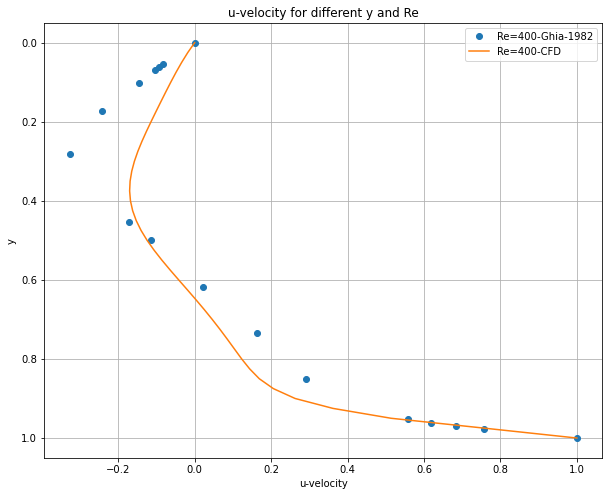

In [15]:
# Plotting
plt.figure(figsize=(10,8))

plt.plot(df['Re=400'].values, df.index.values, 'o', label='Re=400-Ghia-1982') # use .values to get numpy arrays
plt.plot(u[:,int(ny/2)]/c, y, label='Re=400-CFD') # 

plt.xlabel('u-velocity')
plt.ylabel('y')
plt.title('u-velocity for different y and Re')
plt.legend()
plt.gca().invert_yaxis()  # To invert y-axis
plt.grid(True)
plt.show()